# Penguin Data Logistic Regression and PCA

*Data were collected and made available by [Dr. Kristen Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php) and the [Palmer Station, Antarctica LTER](https://pallter.marine.rutgers.edu/), a member of the [Long Term Ecological Research Network](https://lternet.edu/).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# Read in the data, and drop a couple variables

df = pd.read_csv('https://github.com/YData123/sds265-fa22/raw/master/assignments/assn2/penguins.csv')
df = df.drop(columns=['index','year','island'])
df = df.dropna(axis=0)
df

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,39.1,18.7,181.0,3750.0,male
1,Adelie,39.5,17.4,186.0,3800.0,female
2,Adelie,40.3,18.0,195.0,3250.0,female
4,Adelie,36.7,19.3,193.0,3450.0,female
5,Adelie,39.3,20.6,190.0,3650.0,male
...,...,...,...,...,...,...
339,Chinstrap,55.8,19.8,207.0,4000.0,male
340,Chinstrap,43.5,18.1,202.0,3400.0,female
341,Chinstrap,49.6,18.2,193.0,3775.0,male
342,Chinstrap,50.8,19.0,210.0,4100.0,male


In [ ]:
# Next we'll make the sex variable binary, and separate out
# species as the label to predict

species = list(set(df['species']))
df['class'] = LabelEncoder().fit_transform(df['species'])
sex = [int(list(df['sex'])[j]=='male') for j in range(len(df))]
df['sex'] = sex
df = df.drop(columns=['species'])
df

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,class
0,39.1,18.7,181.0,3750.0,1,0
1,39.5,17.4,186.0,3800.0,0,0
2,40.3,18.0,195.0,3250.0,0,0
4,36.7,19.3,193.0,3450.0,0,0
5,39.3,20.6,190.0,3650.0,1,0
...,...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,1,1
340,43.5,18.1,202.0,3400.0,0,1
341,49.6,18.2,193.0,3775.0,1,1
342,50.8,19.0,210.0,4100.0,1,1


### 1.1 Plotting the data

Initial thoughts on plotting the data:
1. The graph (0,4) tells us that female penguins tend to have less bill lengths. It is intuitively true due to common sense. There are two data points a little far away from the others. They could be outliers.
2. The graph (0,4),(1,4),(2,4), and (3,4) tell us female penguins tend to have less bill lengths, bill depths, flipper lengths, and body mass than male penguins, which is intuitively true.
3. (3,2) tells us that a penguin with larger body mass tends to have a longer flipper. It makes sense since the penguin with larger body mass may be of larger body size. No apparent outliers can be found in this graph.
4. (2,1) seems to have two clusters. For each cluster, flipper length and bill depth seem to have a positive correlation. Not apparent outliers can be found.

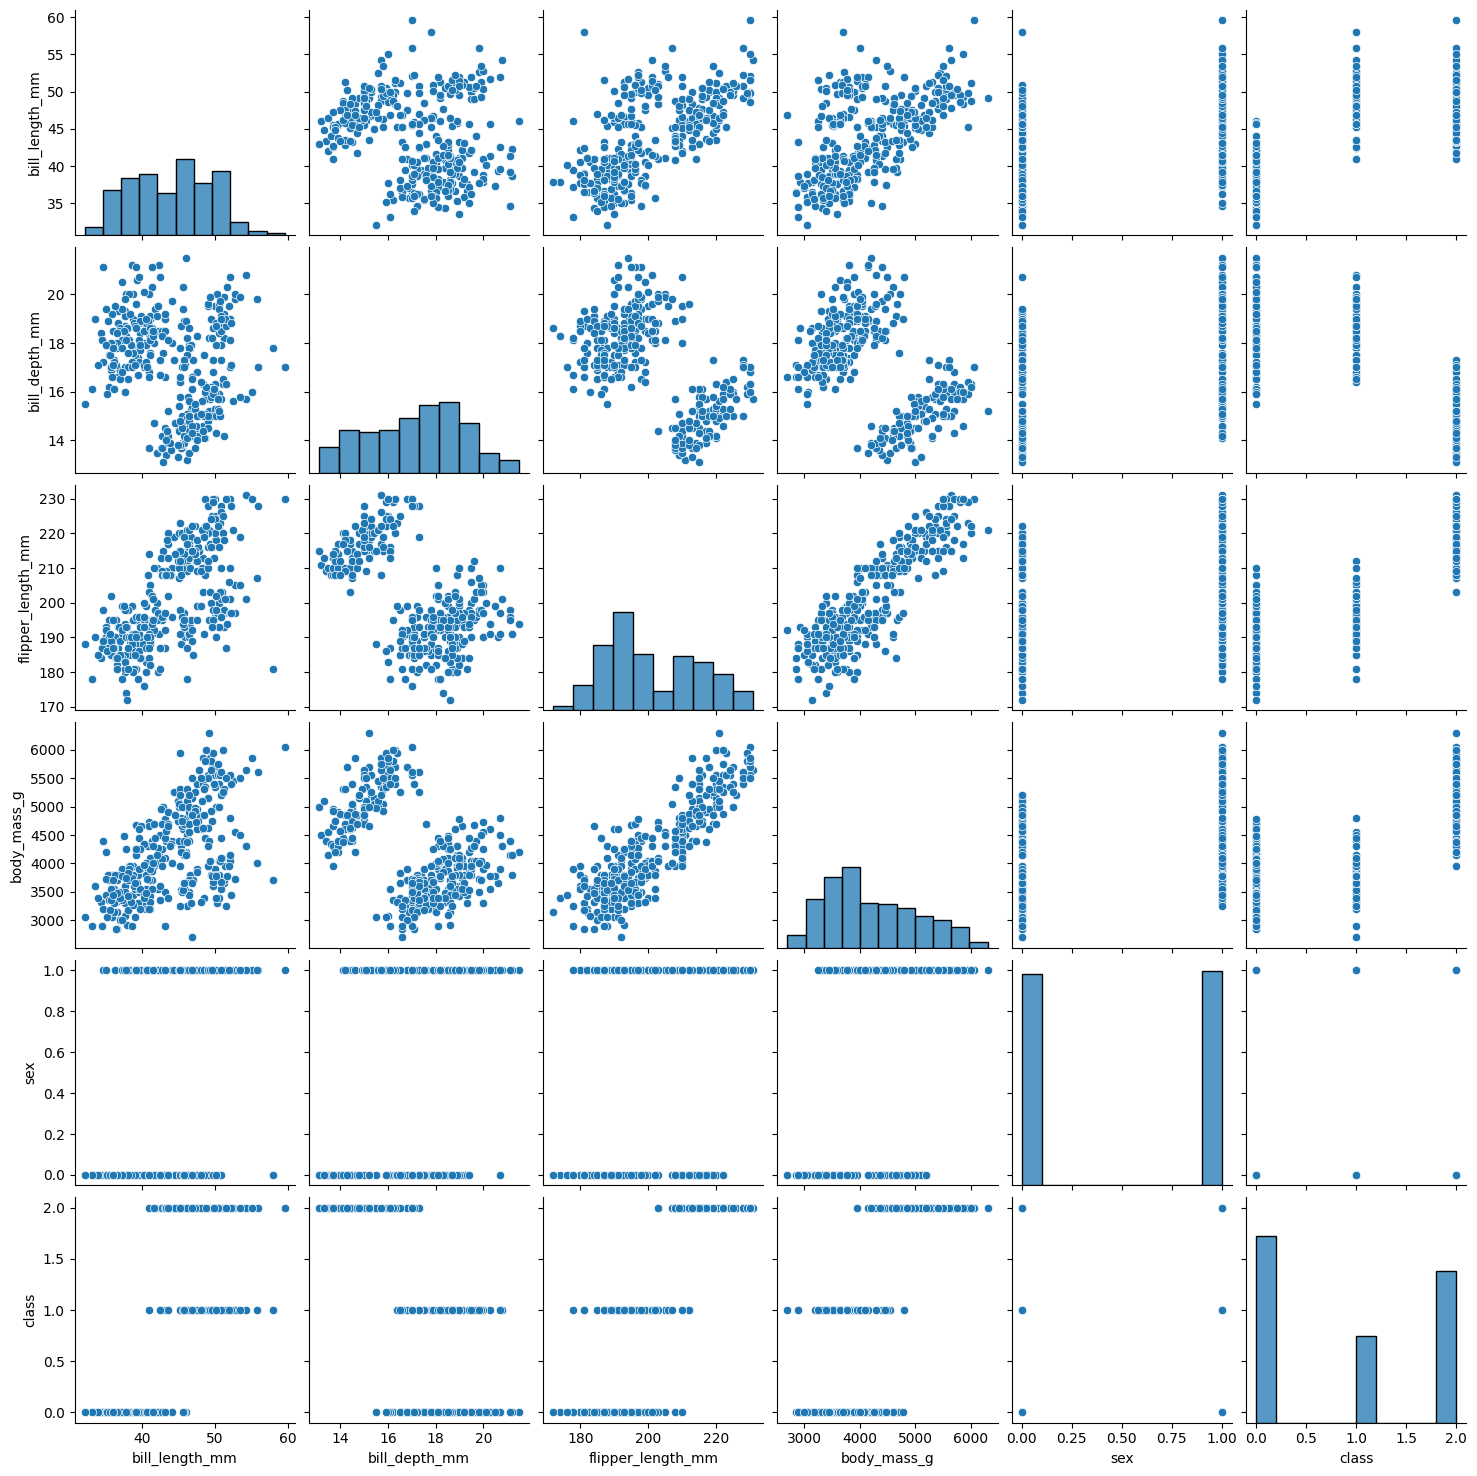

In [ ]:
_ = sns.pairplot(df)

In [ ]:
def plot_features(df, feature1_name, feature2_name):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    colors = ['orange', 'pink', 'lightgreen']
    species = ['Adelie', 'Chinstrap', 'Gentoo']

    for c in range(3):
        mask = (df['class']==c)
        plt.scatter(df[feature1_name][mask],
                    df[feature2_name][mask],
                    color=colors[c], label=species[c])

    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.legend(loc='upper left')
    plt.show()


### 1.1 Plotting the data (continued)

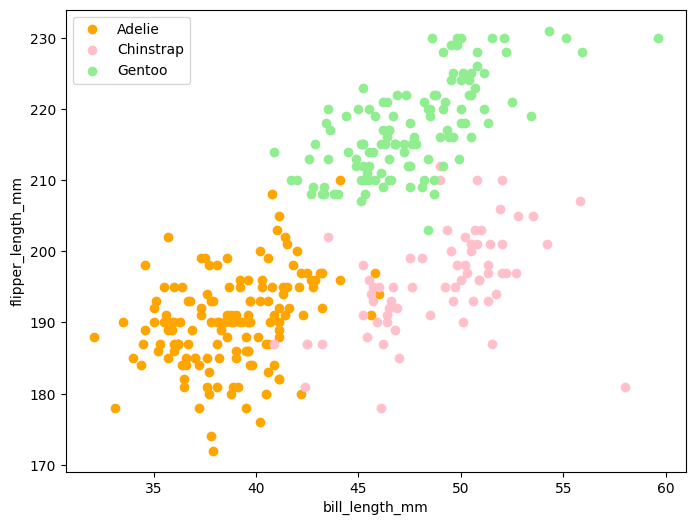

In [ ]:
plot_features(df, 'bill_length_mm', 'flipper_length_mm')

These features seem to be good for classification since different classes are well separated in this graph.

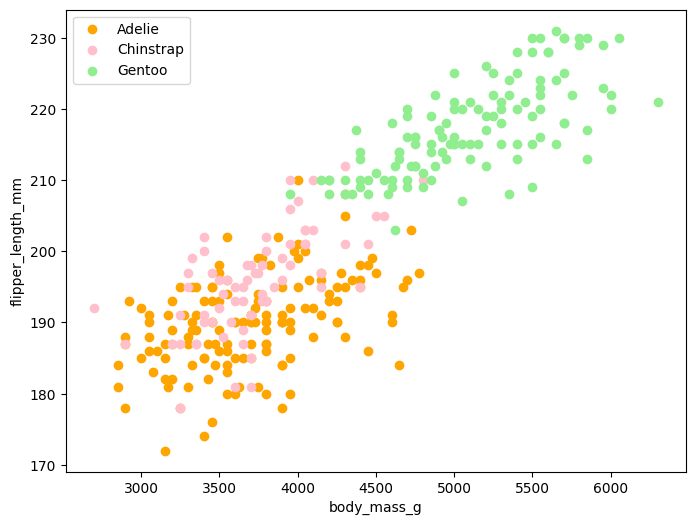

In [ ]:
plot_features(df, 'body_mass_g', 'flipper_length_mm')

These features seem not good for classification since Chinstrap and Adelie can not be well separated in this graph.

### 1.2 Standardize the data

In [ ]:
y = np.array(df['class'])
X = df.copy()
X = X.drop(columns=['class'])
X

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,1
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
4,36.7,19.3,193.0,3450.0,0
5,39.3,20.6,190.0,3650.0,1
...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,1
340,43.5,18.1,202.0,3400.0,0
341,49.6,18.2,193.0,3775.0,1
342,50.8,19.0,210.0,4100.0,1


In [ ]:
# Standardize the data, so that each column of `X` has mean zero and standard deviation one.
for i in range(5):
    X.iloc[:,i] = (X.iloc[:,i]-np.mean(X.iloc[:,i]))/np.std(X.iloc[:,i])

The key point is we add a penalty(Ridge). The penalty $\lambda \sum_i |\beta_i|^2$ shrinks $\|\beta\|_2$ to zero, where $\beta_i$'s have equal contribution. So it is necessary to ensure that the features have equal scales. For example, if we convert $x_i$ to a much smaller unit, $\beta_i$ would be big, the penalty would be dominated by $\beta_i$.

### 1.3 Fit logistic regressions

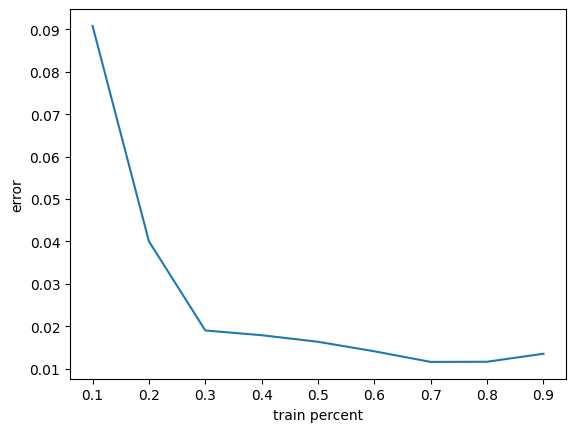

In [ ]:
lr = LogisticRegression(penalty='l2', C=.1, multi_class='multinomial')

lr_error_rate = []
trials = 100
train_percent = np.linspace(.1, .9, 9)

# For each training set percentage, create train/test split accordingly
# and run logistic regression 100 times and calculate the average error rate

"""
function input:
  X: data
  y: label
  ratio: train data percentage
  trails: number of trails to run

function return:
  the average error rate with this train data percentage
"""

def get_err_rate(X, y, ratio, trials):
    # todo:
    errs = []
    lr = LogisticRegression(penalty='l2', C=.1, multi_class='multinomial')
    for trial in np.arange(trials):
         X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=p)
         lr.fit(X_train, y_train)
         err = np.mean(lr.predict(X_test) != y_test)
         errs.append(err)
    return np.mean(errs)

# Use get_err_rate to find the error rate for respective split size
for p in train_percent:
    lr_error_rate.append(get_err_rate(X, y, p, trials))


plt.plot(train_percent, lr_error_rate)
plt.xlabel('train percent')
plt.ylabel('error')
plt.show()

### 1.4 Choose good feature pair

In [ ]:
ratio = 0.7

err = np.zeros([5,5])

for i in range(5):
    for j in range(5):
        if i < j:
            err[i, j] = get_err_rate(X.iloc[:,[i,j]], y, ratio, 200)

print(err)

[[0.         0.05735294 0.04867647 0.06441176 0.23455882]
 [0.         0.         0.19397059 0.19191176 0.22823529]
 [0.         0.         0.         0.21338235 0.21191176]
 [0.         0.         0.         0.         0.21970588]
 [0.         0.         0.         0.         0.        ]]


Pair (0,2): bill_length and flipper_length is the best pair with an error rate of 0.0476.

### 1.5 Visualize the decision boundries

In [ ]:
def plot_decision_boundaries(X, y, model, error):
    X2 = np.array(X)
    b = model.intercept_
    beta = model.coef_.T
    colors = ['orange', 'pink', 'lightgreen']
    h = 0.015
    x_min, x_max = X2[:, 0].min() - .5, X2[:, 0].max() + .5
    y_min, y_max = X2[:, 1].min() - .5, X2[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.c_[xx.ravel(), yy.ravel()], beta) + b
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8,8))
    plt.contourf(xx, yy, Z, levels=[0,.5,1.5,2.5], colors=colors, alpha=0.5)
    for c in range(3):
        mask = (y==c)
        plt.scatter(X2[np.array(mask),0], X2[np.array(mask),1], color=colors[c], label=species[c])

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.legend(loc='upper left')
    plt.title('error rate: %.2f' % error)
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])

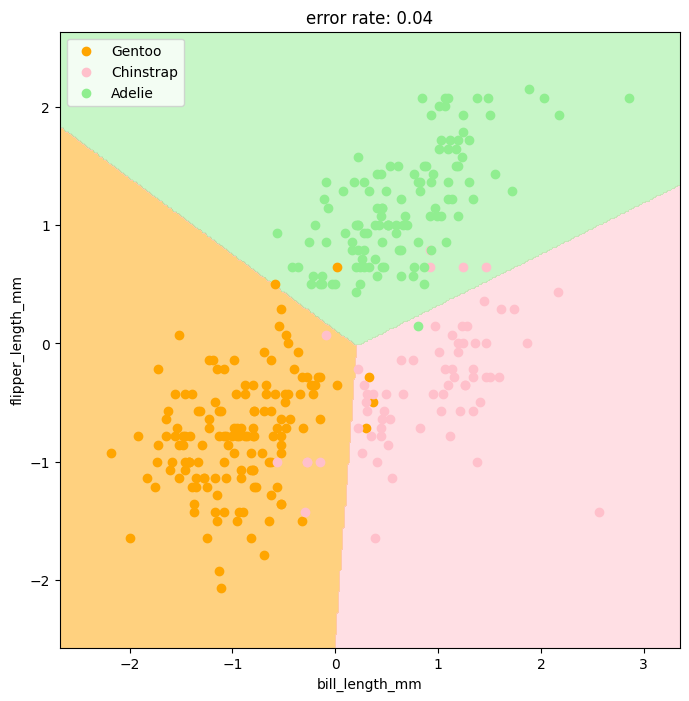

In [ ]:
# Best pair of features
f1,f2 = ('bill_length_mm','flipper_length_mm')
X1 = X[[f1,f2]]
X_train, X_test, y_train, y_test = train_test_split(X1, y, train_size=0.8)
lr.fit(X_train,y_train)
error = np.mean(lr.predict(X_test) != y_test)
plot_decision_boundaries(X1, y, lr, error)

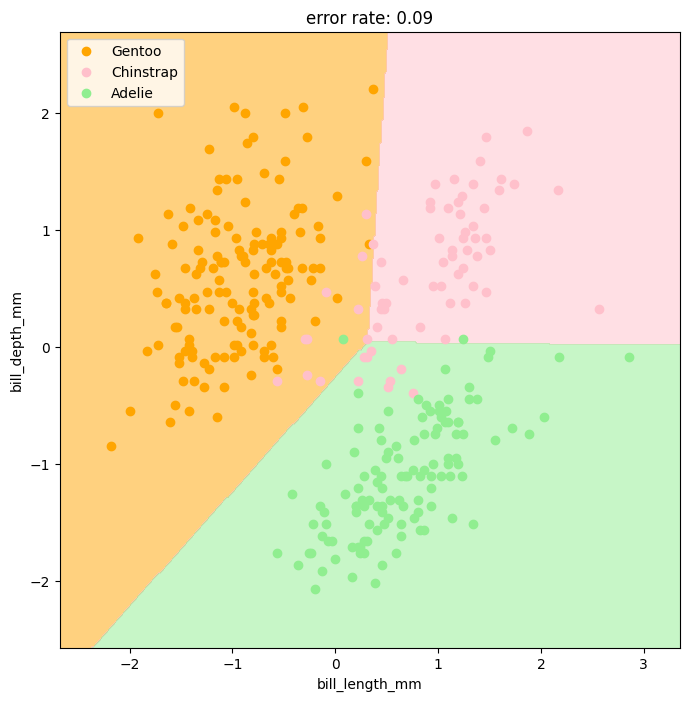

In [ ]:
# Additional pair of features
f1,f2 = ('bill_length_mm','bill_depth_mm')
X1 = X[[f1,f2]]
X_train, X_test, y_train, y_test = train_test_split(X1, y, train_size=0.8)
lr.fit(X_train,y_train)
error = np.mean(lr.predict(X_test) != y_test)
plot_decision_boundaries(X1, y, lr, error)

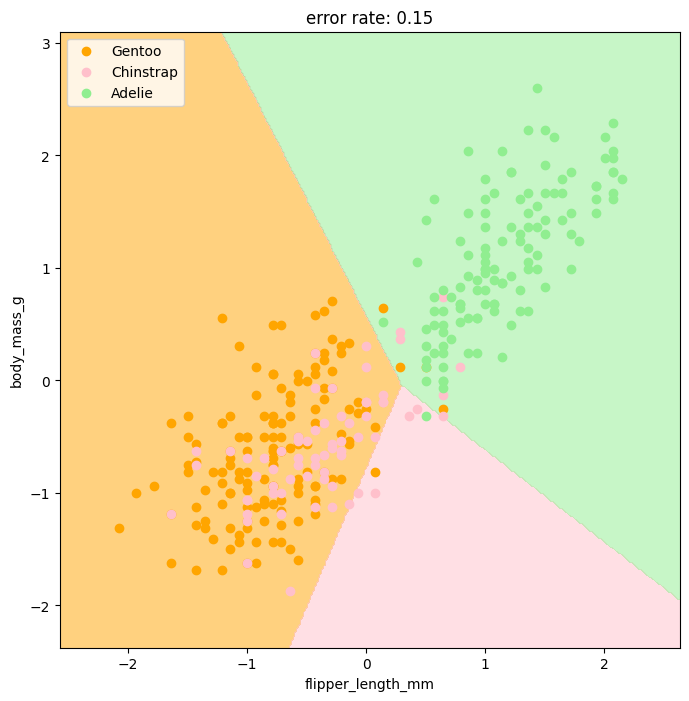

In [ ]:
# Additional pair of features
f1,f2 = ('flipper_length_mm','body_mass_g')
X1 = X[[f1,f2]]
X_train, X_test, y_train, y_test = train_test_split(X1, y, train_size=0.8)
lr.fit(X_train,y_train)
error = np.mean(lr.predict(X_test) != y_test)
plot_decision_boundaries(X1, y, lr, error)

The first two graphs look good. The third graph fails to classify the Chinstrap since ('flipper_length', 'body_mass') is not a good pair for this LR task.

### 2.1 Run Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)

pv1 = pca.components_[0] # your code here
pv2 = pca.components_[1] # your code here
pcs = pca.fit_transform(X) # your code here

principalX = pd.DataFrame(data = pcs, columns = ['PC1', 'PC2'])

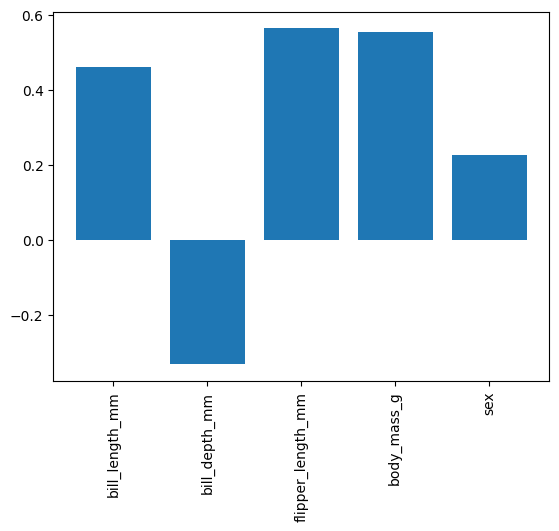

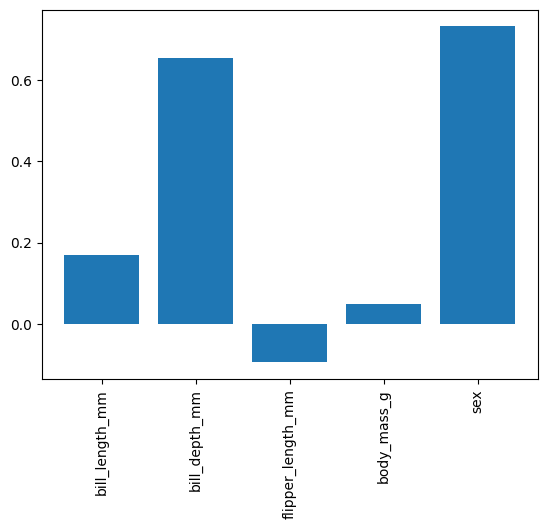

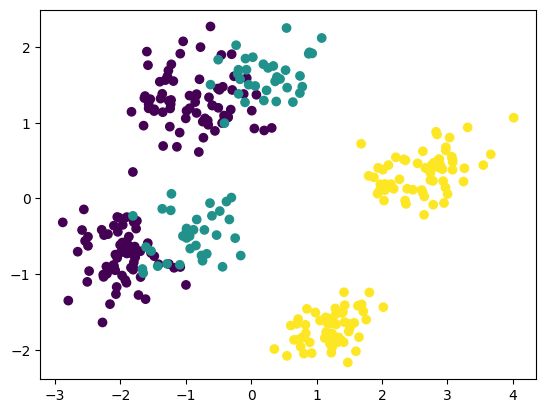

In [ ]:
plt.bar(range(5), pv1)
plt.xticks(range(5), X.columns, rotation='vertical')
plt.show()

plt.bar(range(5), pv2)
plt.xticks(range(5), X.columns, rotation='vertical')
plt.show()

plt.scatter(principalX.iloc[:, 0], principalX.iloc[:, 1], c = y)
plt.show()

### 2.2 Visualize the decision boundaries

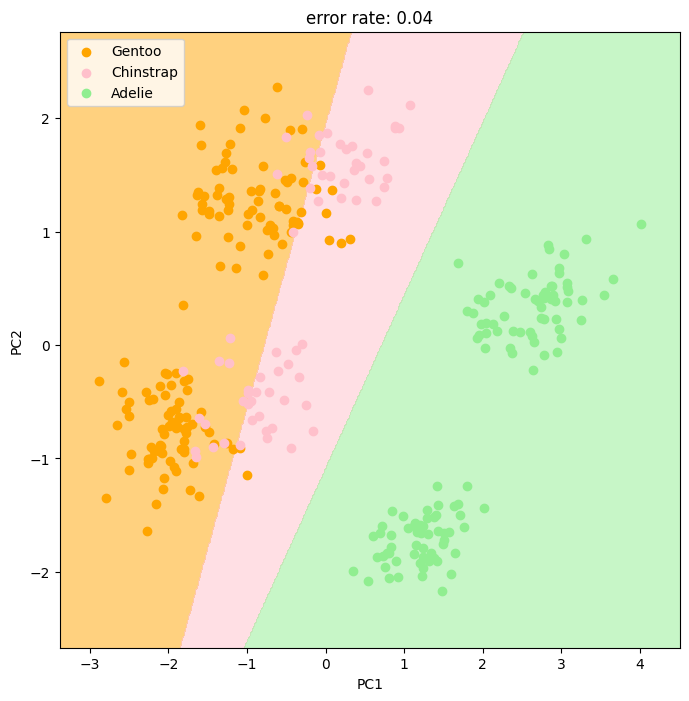

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(principalX, y, train_size=0.8, random_state=265)
lr = LogisticRegression(multi_class='multinomial')
lr.fit(X_train, y_train)
error = np.mean(lr.predict(X_test) != y_test)
plot_decision_boundaries(principalX, y, lr, error)